# PseudoMetric 

To optimize the joint models and especially to find good weights for loss mixing, we derive a pseudo metric in this notebook. It uses information, that can be inferred from the data (clonotype) or is typically present in most of these datasets (cell type). It is derived from an analysis, that we conducted on the Haniffa dataset, where we hand-tuned gene expression vs TCR loss to obtain visually convincing UMAPs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
import sys
sys.path.append('../../')
import tcr_embedding as tcr

## Load the data

In [3]:
path_data = '../../data/Haniffa/v3_conditional.h5ad'
data_full = sc.read_h5ad(path_data)
data_train = data_full[data_full.obs['set']=='train']
data_val = data_full[data_full.obs['set']=='val']

## Load the Model

In [4]:
path_poe = '../../saved_models/haniffa/haniffa_poe_3e_3_cond_patient_id_best_rec_model_trial_8.pt'
path_cc = '../../saved_models/haniffa/haniffa_concat_3e_3_cond_patient_id_best_rec_model_trial_15.pt'
path_rna = '../../saved_models/haniffa/haniffa_rna_zdim_cond_patient_id_best_rec_model.pt'
path_tcr = '../../saved_models/haniffa/haniffa_tcr_zdim_cond_patient_id_best_rec_model.pt'

model_file_poe = torch.load(path_poe)
model_file_cc = torch.load(path_cc)
model_file_rna = torch.load(path_rna)
model_file_tcr = torch.load(path_tcr)

params_poe = model_file_poe['params']
params_cc = model_file_cc['params']
params_rna = model_file_rna['params']
params_tcr = model_file_tcr['params']

model_poe = tcr.utils_training.init_model(params_poe, model_type='PoE', adata=data_full, dataset_name='haniffa', 
                                          conditional='patient_id')
model_cc = tcr.utils_training.init_model(params_cc, model_type='Concat', adata=data_full, dataset_name='haniffa', 
                                          conditional='patient_id')
model_rna = tcr.utils_training.init_model(params_rna, model_type='RNA', adata=data_full, dataset_name='haniffa', 
                                          conditional='patient_id')
model_tcr = tcr.utils_training.init_model(params_tcr, model_type='TCR', adata=data_full, dataset_name='haniffa', 
                                          conditional='patient_id')

model_poe.load(path_poe)
model_cc.load(path_cc)

## Derive the Latent spaces

In [5]:
latent_poe_train = model_poe.get_latent([data_train], metadata=['clonotype', 'full_clustering'], batch_size=256)
latent_poe_val = model_poe.get_latent([data_val], metadata=['clonotype', 'full_clustering'], batch_size=256)

latent_cc_train = model_cc.get_latent([data_train], metadata=['clonotype', 'full_clustering'], batch_size=256)
latent_cc_val = model_cc.get_latent([data_val], metadata=['clonotype', 'full_clustering'], batch_size=256)

latent_rna_train = model_rna.get_latent([data_train], metadata=['clonotype', 'full_clustering'], batch_size=256)
latent_rna_val = model_rna.get_latent([data_val], metadata=['clonotype', 'full_clustering'], batch_size=256)

latent_tcr_train = model_tcr.get_latent([data_train], metadata=['clonotype', 'full_clustering'], batch_size=256)
latent_tcr_val = model_tcr.get_latent([data_val], metadata=['clonotype', 'full_clustering'], batch_size=256)

In [6]:
latent_poe_val.obs['clonotype'] = [x.numpy().tolist() for x in latent_poe_val.obs['clonotype']]
latent_poe_train.obs['clonotype'] = [x.numpy().tolist() for x in latent_poe_train.obs['clonotype']]

latent_cc_val.obs['clonotype'] = [x.numpy().tolist() for x in latent_cc_val.obs['clonotype']]
latent_cc_train.obs['clonotype'] = [x.numpy().tolist() for x in latent_cc_train.obs['clonotype']]

latent_rna_val.obs['clonotype'] = [x.numpy().tolist() for x in latent_rna_val.obs['clonotype']]
latent_rna_train.obs['clonotype'] = [x.numpy().tolist() for x in latent_rna_train.obs['clonotype']]

latent_tcr_val.obs['clonotype'] = [x.numpy().tolist() for x in latent_tcr_val.obs['clonotype']]
latent_tcr_train.obs['clonotype'] = [x.numpy().tolist() for x in latent_tcr_train.obs['clonotype']]

## UMAPs

In [7]:
# plotting function for latent spaces
def plot_umaps(adata, n_neighbors=15, min_dist=0.5, title=''):
    print(title)
    adata_tmp = adata.copy()
    sc.pp.neighbors(adata_tmp, n_neighbors=n_neighbors, random_state=42, use_rep='X')
    sc.tl.umap(adata_tmp, min_dist=min_dist, random_state=42)

    groups = ['full_clustering', 'clonotype']
    figs, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i, col in enumerate(groups):
        if col == 'clonotype':
            ax = sc.pl.umap(adata_tmp, color=col, title=None, color_map=sb.color_palette("viridis", as_cmap=True), 
                            show=False, ax=axes[i])
        else:
            ax = sc.pl.umap(adata_tmp, color=col, title=None, show=False, ax=axes[i])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(None)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


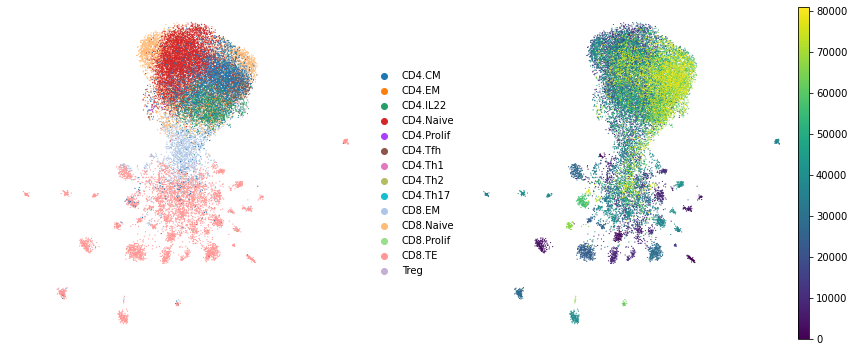

In [8]:
plot_umaps(latent_poe_val)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


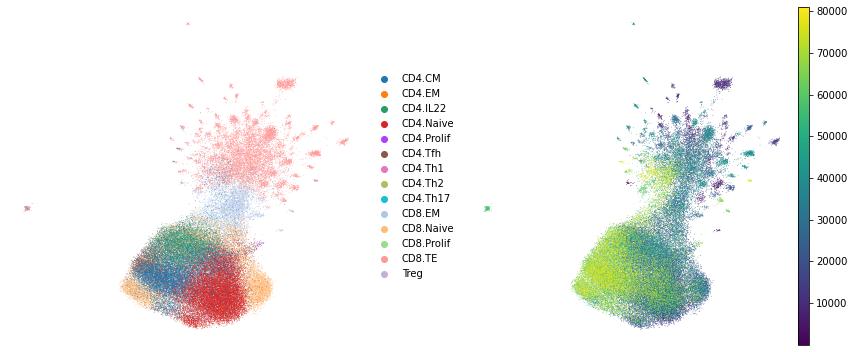

In [9]:
plot_umaps(latent_poe_train)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


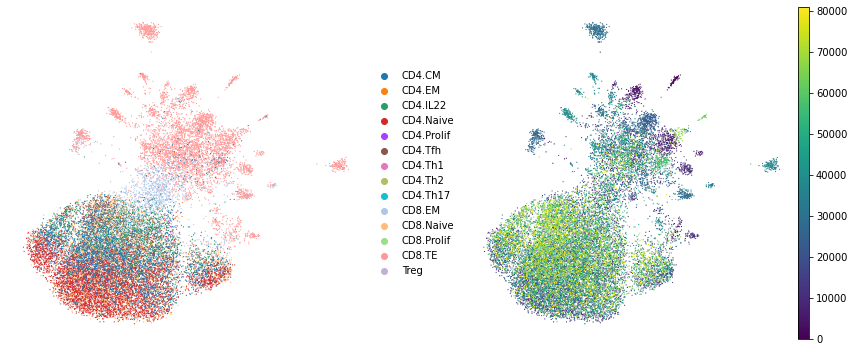

In [10]:
plot_umaps(latent_cc_val)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


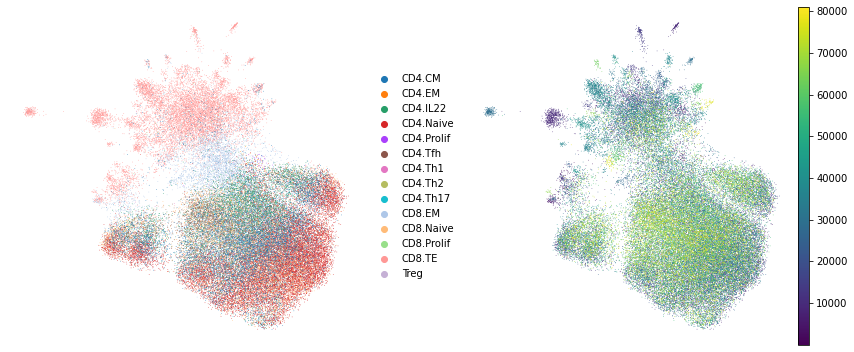

In [11]:
plot_umaps(latent_cc_train)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


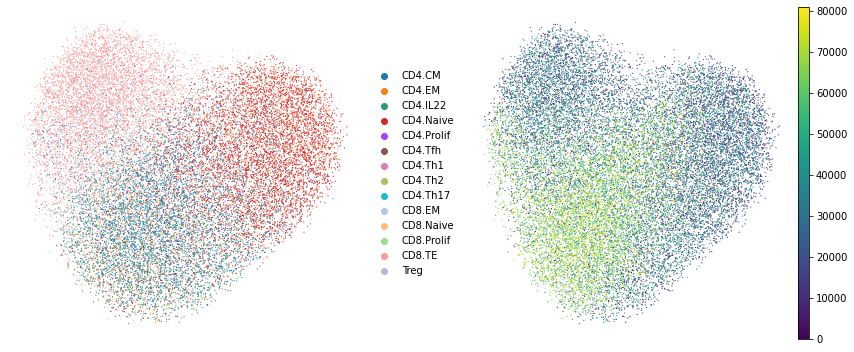

In [12]:
plot_umaps(latent_rna_val)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


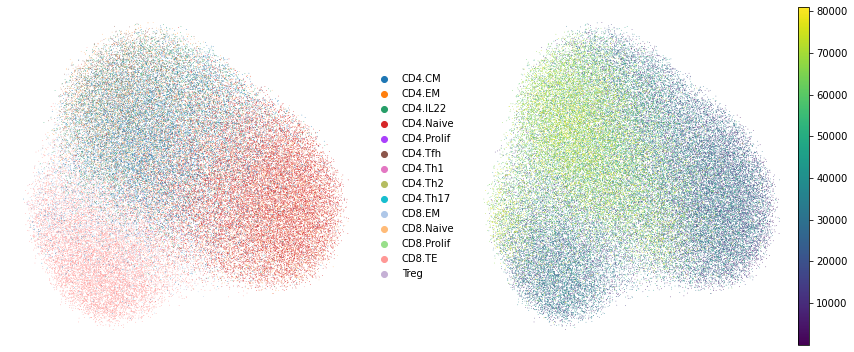

In [13]:
plot_umaps(latent_rna_train)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


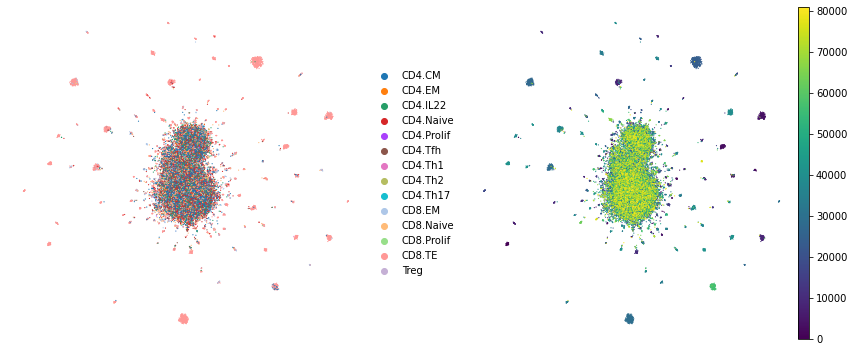

In [14]:
plot_umaps(latent_tcr_val)

... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


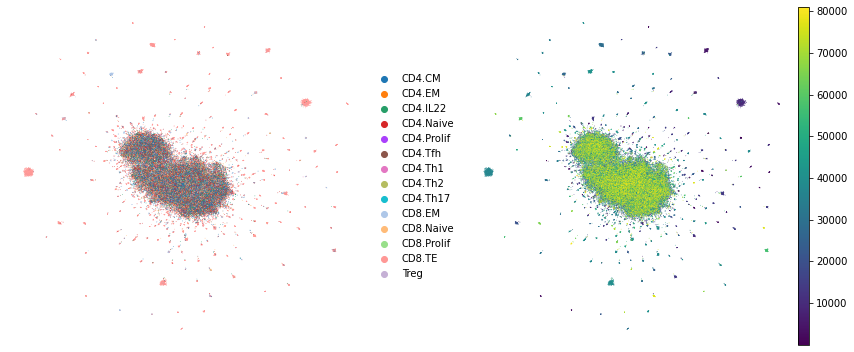

In [15]:
plot_umaps(latent_tcr_train)

## Define the metrics

KNN metric? inside the dataset define nearest neigbhor. If of same class +1

In [16]:
def metric(column_name, metric_keys):
    def classification_report(latent):
        con = latent.obsp['connectivities'].A.astype(np.bool)
        nearest_neighbor_label = [latent.obs[column_name].values[row].tolist()[0] for row in con]
        result = skl.classification_report(latent.obs[column_name], nearest_neighbor_label, 
                                           output_dict=True)
        for key in metric_keys:
            result = result[key]
        return result
    return classification_report

In [21]:
metrics = {
    'f1_cellType': metric('full_clustering', ['weighted avg', 'f1-score']),
    'acc_cellType': metric('full_clustering', ['accuracy']),
    
    'f1_clonotype': metric('clonotype', ['weighted avg', 'f1-score']),
    'acc_clonotype': metric('clonotype', ['accuracy']),
    
}

## Evaluate the metric

In [22]:
latent_spaces = {
    'PoE_train': latent_poe_train,
    'PoE_val': latent_poe_val,
    'Concat_train': latent_cc_train,
    'Concat_val': latent_cc_val,
    'RNA_train': latent_rna_train,
    'RNA_val': latent_rna_val,
    'TCR_train': latent_tcr_train,
    'TCR_val': latent_tcr_val,
}

In [23]:
metric_scores = {}
for name_metric in metrics.keys():
    metric_scores[name_metric] = []

for name_latent, latent in latent_spaces.items():
    print(f'-{name_latent}')
    sc.pp.neighbors(latent, n_neighbors=2, knn=True)
    for name_metric, metric_func in metrics.items():
        score = metric_func(latent)
        metric_scores[name_metric].append(score)


-PoE_train
-PoE_val
-Concat_train
-Concat_val
-RNA_train
-RNA_val
-TCR_train
-TCR_val


In [24]:
df_metric = pd.DataFrame(metric_scores, index=latent_spaces.keys())
df_metric

,f1_cellType,acc_cellType,f1_clonotype,acc_clonotype
PoE_train,0.634151,0.637255,0.145066,0.151217
PoE_val,0.630928,0.634099,0.207467,0.214855
Concat_train,0.550544,0.555642,0.109993,0.114594
Concat_val,0.555421,0.560243,0.167908,0.173458
RNA_train,0.429970,0.430454,0.007110,0.007084
RNA_val,0.437099,0.436794,0.014662,0.014169
TCR_train,0.354000,0.359698,0.218146,0.224790
TCR_val,0.377580,0.382849,0.265427,0.272550
